In [1]:
%matplotlib inline

## [Ensembles](https://scikit-learn.org/stable/modules/ensemble.html)
- Goal: combine predictions from multiple estimators to improve robustness.
- Two strategy types:
    - **averaging** (examples: Bagging, Forests, ...)
    - **boosting** (examples: Adaboost, Gradient trees, ...)

## Bagging Methods: [Classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) and [Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor)
- algorithms that build copies of an estimator from random subsets of a dataset.
- variants usually distinguished by how random training subsets are chosen:
    - **Pasting**: random subsets of samples
    - **Bagging**: random subsets of samples with replacements
    - **Random Subspaces**: subsets of features
    - **Random Patches**: subsets of both samples & features
- ```max_samples``` and ```bootstrap_features``` control how samples & features are used.

## Example: Bagged Regression vs a single Estimator performance
- Regression errors can be broken down into bias, variance & noise.
- UPPER LEFT: 
    - predictions (dark red) of a single decision tree
    - trained on random dataset LS (blue dots) of a toy 1D function
    - other predictions (light red) of other DTs on other subsets
- LOWER LEFT:
    - pointwise decomposition of expected mean squared error of a single DT
    - confirms a low bias term (blue), large variance term (green)
    - illustrates noise component ~ constant.
- UPPER, LOWER RIGHT:
    - same plots using bagging ensembles

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

In [3]:
# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


In [4]:
def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples = n_train, 
                    noise     = noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples = n_test, 
                          noise     = noise, 
                          n_repeat  = n_repeat)


Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0199 (error) = 0.0005 (bias^2)  + 0.0094 (var) + 0.0098 (noise)


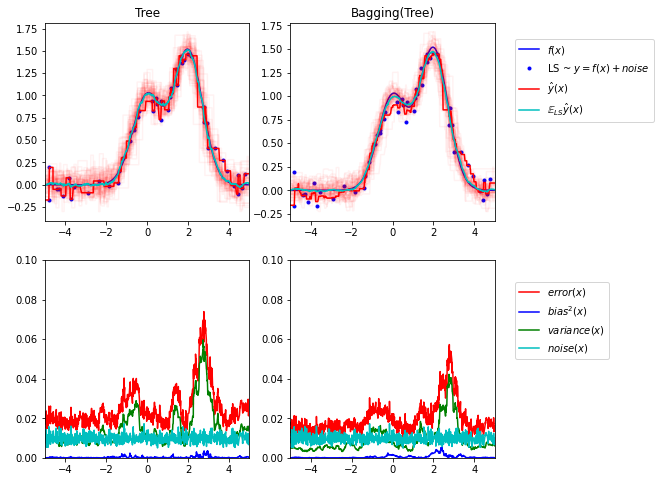

In [8]:
plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    y_noise  = np.var(y_test, axis=1)
    y_bias   = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var    = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))
plt.subplots_adjust(right=.75)
plt.show()

## Random Forests: [Classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) and [Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
- Each tree is built from a bootstrap (ie, with replacement) sample from the training dataset.
- Returns averaged prediction of a set of classifiers, which should decrease the estimator variance.
- Like decision trees, random forests also can handle multi-output problems.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, 
                           n_features=4,
                           n_informative=2, 
                           n_redundant=0,
                           random_state=0, 
                           shuffle=False)

clf = RandomForestClassifier(max_depth=2, 
                             random_state=0)
clf.fit(X, y)
print(clf.predict([[0, 0, 0, 0]]))

[1]


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, 
                       n_informative=2,
                       random_state=0, 
                       shuffle=False)

regr = RandomForestRegressor(max_depth=2, 
                             random_state=0)
regr.fit(X, y)
print(regr.predict([[0, 0, 0, 0]]))

[-8.32987858]


## Extremely Randomized Trees: [Classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) and [Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor)
- Random subsets of candidate features are used (as in RFs) - instead of looking for the most discriminative thresholds, *thresholds are picked at random for each feature. The best ones are picked as splitting rules.*
- Slightly better variance, slight increase in bias.
- Parameters:
    - ```n_estimators``` (number of trees in forest), ```max_features``` (size of random feature subsets, used when splitting nodes)
    - empirical "good" values: ```max_features=None``` (always considering all features instead of random subset) for regressions, ```max_features="sqrt"``` for classifications.
    - Best params should always be cross-validated.
- Parallelization:
    - controlled by ```n_jobs``` (one per machine core). Uses all available cores if ```n_jobs=-1```.    

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples=10000, 
                  n_features=10, 
                  centers=100,
                  random_state=0)

clf = DecisionTreeClassifier(
    max_depth=None, 
    min_samples_split=2,
    random_state=0)

scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())

clf = RandomForestClassifier(
    n_estimators=10, 
    max_depth=None,
    min_samples_split=2, 
    random_state=0)

scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())

clf = ExtraTreesClassifier(
    n_estimators=10, 
    max_depth=None,
    min_samples_split=2, 
    random_state=0)

scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean() > 0.999)

0.9823000000000001
0.9997
True


## Example: Plot decision surfaces, iris dataset, 4 classifiers
- 1) std decision tree
- 2) random forest
- 3) extra trees
- 4) Adaboost

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

In [20]:
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(
              max_depth = None),
          RandomForestClassifier(
              n_estimators = n_estimators),
          ExtraTreesClassifier(
              n_estimators = n_estimators),
          AdaBoostClassifier(
              DecisionTreeClassifier(
                  max_depth=3),
                  n_estimators = n_estimators)]

DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators with features [0, 1] has a score of 0.8533333333333334
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.9933333333333333


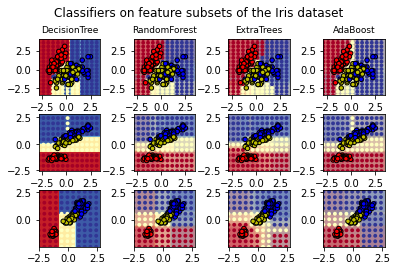

In [21]:
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            plt.title(model_title, fontsize=9)

        # plot decision boundary using mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()

## Example: Find pixel importances with parallel random forest
- pixel importance metric: impurity-based.
- the hotter the pixel, the more important.

In [16]:
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

n_jobs = 1
data   = fetch_olivetti_faces()
X, y   = data.data, data.target
mask   = y < 5  # Limit to 5 classes
X      = X[mask]
y      = y[mask]

Fitting ExtraTreesClassifier on faces data with 1 cores...
done in 1.52s


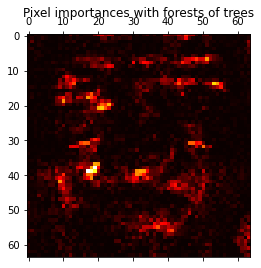

In [17]:
# Build a forest and compute the pixel importances
print("Fitting ExtraTreesClassifier on faces data with %d cores..." % n_jobs)
t0 = time()
forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X, y)
print("done in %0.2fs" % (time() - t0))
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees")
plt.show()

## [Random Tree Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding)
- Performs unsupervised data transform
- Encodes data by indices of the leaves where the data resides, leading to a sparse high-D representation - can be computed very efficiently.
- Given that neighboring data points are likely to be in the same leaf, this tranform implicitly performs density estimation.

## Example: Hashing Feature Transforms using Totally Random Trees.
- Neighboring points often share the leaf on a tree - therefore large parts of their hashed representation.
- This helps to separate two concentric circles using principal components of their transformed data.
- High-D spaces: linear classifiers often are a good choice; BernoulliNB is a particularly good option for sparse binary data.
- Bottom row: comparison of decision boundary, BernoulliNB (transformed space) vs ExtraTreesClassifier (original data)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB

In [23]:
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

hasher = RandomTreesEmbedding(n_estimators=10, 
                              random_state=0, 
                              max_depth=3)
X_transformed = hasher.fit_transform(X)

# dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)

# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, y)

# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(
    max_depth=3, 
    n_estimators=10, 
    random_state=0)
trees.fit(X, y)

ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)

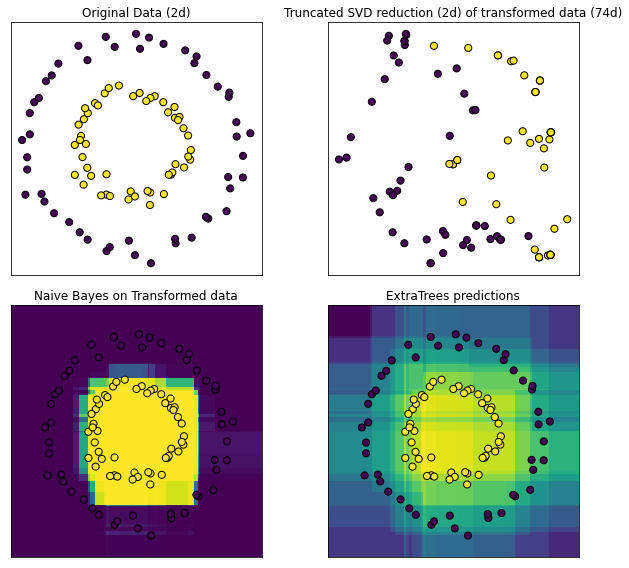

In [24]:
# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))

ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Truncated SVD reduction (2d) of transformed data (%dd)" %
             X_transformed.shape[1])
ax.set_xticks(())
ax.set_yticks(())

# Plot the decision in original space. For that, we will assign a color
# to each point in the mesh [x_min, x_max]x[y_min, y_max].
h = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()

## AdaBoost - [Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) and [Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)
- Key concept: fit a sequence of weak learners on repeatedly modified versions of the data - combine predictions with a *weighted majority voting scheme*.
- Data is modified with a weight vector after each iteration; incorrect training samples get increased weights; correct guesses get decreased weights. As training progresses, difficult examples get ever-increasing influence - subsequent weak learners are forced to concentrate on them."

## Example: Adaboost comparison
- classification error: decision stump vs decision tree vs boosted decision stump
- targets Y = non-linear function of 10 input features.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

n_estimators     = 400
learning_rate    = 1.
X, y             = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X_test, y_test   = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator = dt_stump,
    learning_rate  = learning_rate,
    n_estimators   = n_estimators,
    algorithm      = "SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator = dt_stump,
    learning_rate  = learning_rate,
    n_estimators   = n_estimators,
    algorithm      = "SAMME.R")
ada_real.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

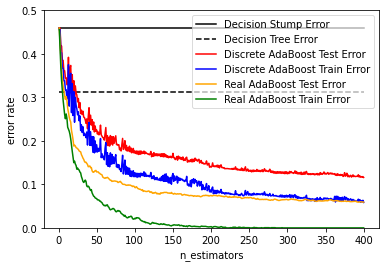

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err       = np.zeros((n_estimators,))
ada_discrete_err_train = np.zeros((n_estimators,))
ada_real_err           = np.zeros((n_estimators,))
ada_real_err_train     = np.zeros((n_estimators,))

for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

## Example: Decision Trees w/ AdaBoost, Multiclass Outputs
- Dataset: 10-D std normal distribution; 3 classes defined by nested concentric 10-D spheres such that roughtly equal numbers of samples are in each class.
- Compares SAMME and SAMME.R algorithms.
- LEFT: each algorithm's test error, after each boosting iteration
- MIDDLE: each algorithm's classification error
- RIGHT: boost weight of each tree

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                               n_classes=3, random_state=1)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

In [29]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors  = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors      = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]


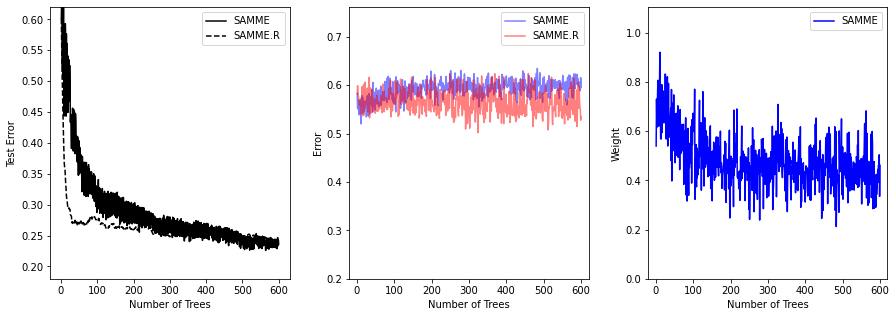

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

## [Gradient Tree Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- Generalizes boosting to arbitrary differentiable loss functions
- Can be used for [classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)
- Key parameters: ```n_estimators``` and ```learning_rate```.
- Loss function options:
    - binomial and multinomial deviance ('deviance')
    - exponential loss ('exponential') - loss robust to mislabeled data.

In [31]:
# fit GB classifier with 100 decision stumps as weak learners

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y            = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(
    n_estimators  = 100, 
    learning_rate = 1.0,
    max_depth     = 1, 
    random_state=0).fit(X_train, y_train)

clf.score(X_test, y_test)

0.913

## [Gradient Tree Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
- Supports multiple loss functions
    - default is least squares ('ls')
    - least absolute deviation ('lad')
    - huber loss ('huber')
    - quantile loss ('quantile')

## Example: Gradient Tree Boosting - Regression
- Diabetes toy dataset
- Using least squares loss & 500 regression trees of depth = 4

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3026.8308


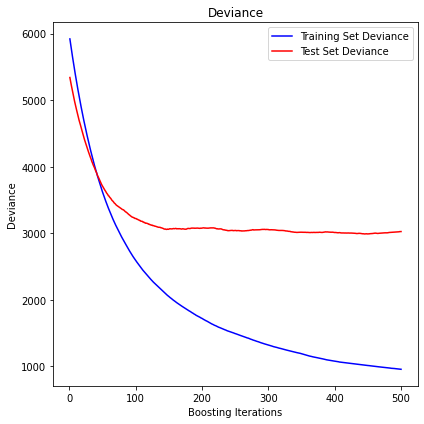

In [33]:
# plot test dataset deviance vs #iterations
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

- Below: example of [Permutation Feature Importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

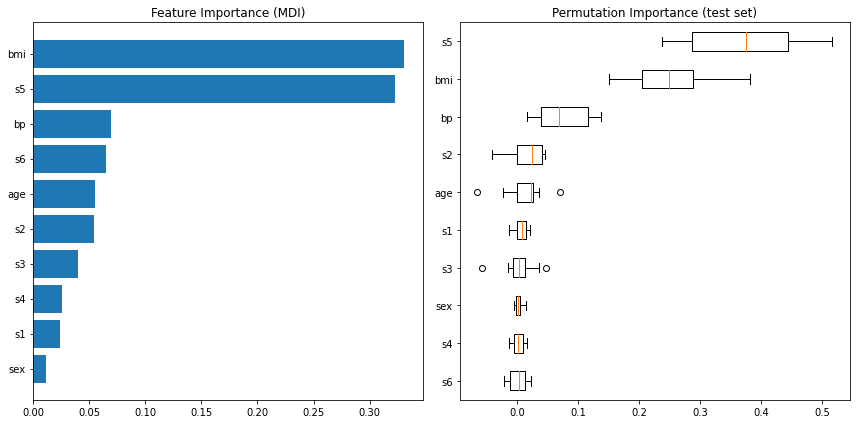

In [34]:
feature_importance = reg.feature_importances_
sorted_idx         = np.argsort(feature_importance)
pos                = np.arange(sorted_idx.shape[0]) + .5
fig                = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(diabetes.feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## [Stochastic Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#f1999)
- Combines gradient boosting with bootstrap averaging (bagging).
- Classifier is trained on a fraction (set by ```subsample```, typically 0.5) of the training data without replacement..

## Example: Gradient Boosting Regularization
- loss function = binomial deviance
- regularization via shrinkage (```learning_rate < 1.0```) improves performance
- stochastic gradient boosting (```subsample < 1.0```) reduces variance via bagging
- subsampling without shrinkage usually does poorly
- another variance-reduction strategy = feature subsampling (via ```max_features```)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X    = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators':      1000, 
                   'max_leaf_nodes':    4, 
                   'max_depth':         None, 
                   'random_state':      2,
                   'min_samples_split': 5}

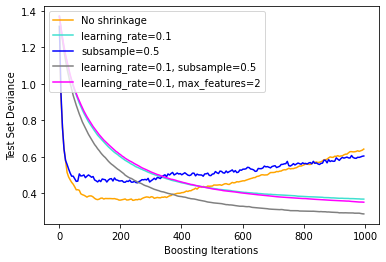

In [36]:
plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

## Histogram-Based Gradient Boosting: [Classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) and [Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
- New in Scikit 0.21, inspired by [LightGBM](https://github.com/Microsoft/LightGBM)
- Can be *orders of magnitude faster* than Gradient Boosting
- Built-in support for missing values (NaNs)
- Bins input samples into integer-valued bins (typically 256), which reduces the number of splitting point decision & leverages integer-based data structures.
- Still experimental!

In [37]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8965

- early stopping enabled by default if number of samples > 10000
- NaNs handled during training by deciding whether missing values should go to left or right child node, based on potential gain.

In [38]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]

gbdt = HistGradientBoostingClassifier(min_samples_leaf=1).fit(X, y)
gbdt.predict(X)

array([0, 0, 1, 1])

- When the "missingness" pattern is predictive, the splits can be handled via whether the feature value is missing. 

In [39]:
X = np.array([0, np.nan, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 1, 0, 0, 1]
gbdt = HistGradientBoostingClassifier(min_samples_leaf=1,
                                      max_depth=2,
                                      learning_rate=1,
                                      max_iter=1).fit(X, y)
gbdt.predict(X)

array([0, 1, 0, 0, 1])

- sample weight support

In [40]:
X = [[1, 0],
     [1, 0],
     [1, 0],
     [0, 1]]
y = [0, 0, 1, 0]
# ignore the first 2 training samples by setting their weight to 0
sample_weight = [0, 0, 1, 1]
gb = HistGradientBoostingClassifier(min_samples_leaf=1)
gb.fit(X, y, sample_weight=sample_weight)

gb.predict([[1, 0]])

gb.predict_proba([[1, 0]])[0, 1]

0.9990209190235209

## [Voting Classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
- Concept: combine different classifiers & use a majority or average predicted probability (soft) vote to predict class labels.

In [41]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr',  clf1), 
                ('rf',  clf2), 
                ('gnb', clf3)],
    voting='hard')

for clf, label in zip(
    [clf1, clf2, clf3, eclf], 
    ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.95 (+/- 0.04) [Logistic Regression]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Ensemble]


## Example: Soft Voting Classifiers
- Returns the class label as argmax of the sum of predicted probabilities.
- Each classifier can be weighted
- Below: 3 classifiers created (Decision Tree, K Neighbors, SVC)
- Weights [2,1,2] used to make the Decision Tree and SVC classifiers 2X as important.

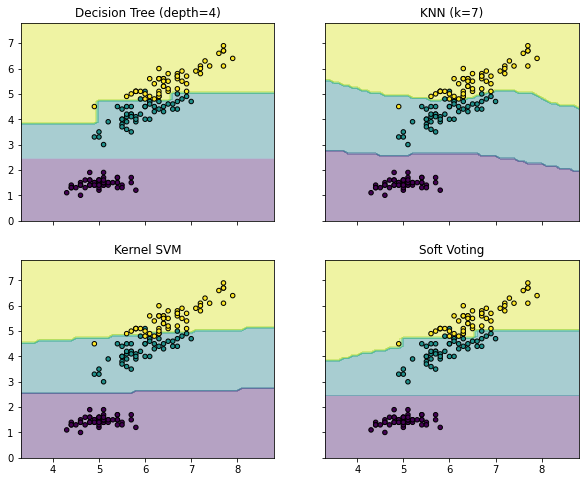

In [42]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

- Voting Classifiers can be combined with Grid Search Cross Validation to tune the params.

In [43]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft')

# optional weights added for each classifier:
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft', weights=[2,5,1])

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

## [Voting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor)

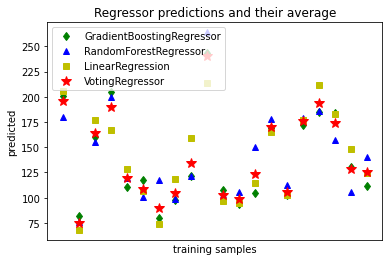

In [44]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

X, y = load_diabetes(return_X_y=True)

# Train classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X, y)

# make first 20 predictions
xt = X[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

plt.figure()
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

## Stacked Generalization: [Classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) and [Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor)
- Stacks the predictions of multiple estimators & fed to final estimator, which is trained with cross-validation.

In [45]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('svr', SVR(C=1, gamma=1e-6))]

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(random_state=42))


from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
from sklearn.metrics import r2_score
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.81


In [46]:
# to get output of stacked estimators:
reg.transform(X_test[:5])

array([[28.78639577, 28.433658  , 22.62294373],
       [35.9633462 , 32.58788457, 23.68491013],
       [14.9718715 , 14.05965525, 16.45282443],
       [25.19918853, 25.54000515, 22.92830073],
       [18.93352627, 19.26508705, 17.0351469 ]])